In [1]:
from keras.preprocessing import image
from keras.layers import Input, Dense
from keras.models import Model

import matplotlib.pyplot as plt

import numpy as np
import os
import random

%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_DIR = "./data"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")


In [114]:
img = image.load_img('data/train/n01443537/images/n01443537_0.JPEG')

x = image.img_to_array(img)  # this is a Numpy array with shape (3, 64, 64)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 64, 64)

In [115]:
# Making sure data is in the right shape
x.shape

(1, 64, 64, 3)

In [118]:
print((x-(255/2))/255)

[[[[ 0.5         0.0372549   0.25294119]
   [ 0.5         0.04509804  0.25294119]
   [ 0.46470588  0.08039216  0.27254903]
   ..., 
   [ 0.31568629  0.42941177  0.42156863]
   [ 0.31176472  0.44509804  0.44117647]
   [-0.00980392  0.14313726  0.13137256]]

  [[ 0.5        -0.01372549  0.24117647]
   [ 0.5         0.00196078  0.24117647]
   [ 0.46470588  0.0372549   0.26078433]
   ..., 
   [ 0.29607844  0.40980393  0.40196079]
   [ 0.28431374  0.42156863  0.40588236]
   [-0.0254902   0.12745099  0.11568628]]

  [[ 0.5        -0.01372549  0.28823531]
   [ 0.5        -0.00196078  0.28823531]
   [ 0.5         0.0254902   0.29607844]
   ..., 
   [ 0.31176472  0.4137255   0.40196079]
   [ 0.28431374  0.42156863  0.39803922]
   [-0.03333334  0.11176471  0.08431373]]

  ..., 
  [[-0.13137256 -0.02156863 -0.22156863]
   [-0.13529412 -0.03333334 -0.22156863]
   [-0.13529412 -0.04509804 -0.2254902 ]
   ..., 
   [-0.16666667 -0.20980392 -0.28039217]
   [-0.19411765 -0.2372549  -0.30784315]
   [-0.

In [47]:
#Model
from keras.models import Model
from keras.layers import *
from keras.callbacks import ModelCheckpoint

## Dataset creation
The dataset is composed of a random subset of images from all 200 classes.

In [120]:
test_size = 500

def load_dataset(n_images_from_class_test=10, test_size=500):
    X_train = []
    X_test = []
    
    # Create training set
    for c in os.listdir(TRAIN_DIR):
        c_dir = os.path.join(TRAIN_DIR, c, 'images')
        c_imgs = os.listdir(c_dir)
        random.shuffle(c_imgs)
        
        for img_name_i in c_imgs[0:n_images_from_class_test]:
            img_i = image.load_img(os.path.join(c_dir, img_name_i))
            x = image.img_to_array(img_i)
            X_train.append(x)
            
    # Create test set
    test_dir = os.path.join(TEST_DIR, 'images')
    test_imgs = os.listdir(test_dir)
    random.shuffle(test_imgs)
    for img_name_i in test_imgs[0:test_size]:
        img_i = image.load_img(os.path.join(test_dir, img_name_i))
        x = image.img_to_array(img_i)
        X_test.append(x)
        
        

    return np.array(X_train), np.array(X_test)
    

In [123]:
X_train_orig, X_test_orig = load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_train.shape[0]))
print ("X_train shape: " + str(X_train.shape))

Number of training examples = 2000
Number of test examples = 2000
X_train shape: (2000, 64, 64, 3)


In [124]:
# S: secret image
input_S = X_train[0:X_train.shape[0] // 2]

# C: cover image
input_C = X_train[X_train.shape[0] // 2:]

# TODO Do the same for test images

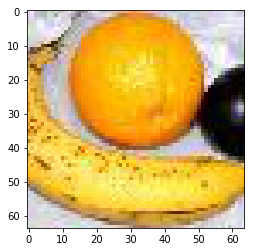

In [126]:
plt.imshow(X_train[1])

## Model

In [143]:
from keras.layers import concatenate, Conv2D
import keras.backend as K

noise_std = 0.01
beta = 1.0
def model_loss(y_true, y_pred):
    s_true, c_true = y_true[...,0:3], y_true[...,3:6]
    s_pred, c_pred = y_pred[...,0:3], y_pred[...,3:6]
    
    s_loss = K.sum(K.square(s_true - s_pred))
    c_loss = K.sum(K.square(c_true - c_pred))
    
    return c_loss + beta * s_loss

def create_model(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    
    # Prep network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3')(input_S)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4')(input_S)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(input_S)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x = concatenate([input_C, x])
    
    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)
    
    # Gaussian noise
    output_Cprime_noise = GaussianNoise(noise_std, name='output_C_noise')(output_Cprime)
    
    # Reveal network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(output_Cprime_noise)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(output_Cprime_noise)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(output_Cprime_noise)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Sprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S')(x)

    assert (output_Cprime.shape[3] == 3)
    assert (output_Sprime.shape[3] == 3)
    
    # Models
    autoencoder = Model(inputs=[input_S, input_C], outputs=concatenate([output_Sprime, output_Cprime]), name = 'AutoEncoderModel')

    # encoder = Model(inputs=[input_S, input_C], outputs=output_Cprime)
    
    # encoded_input = Input(shape=(input_size))
    # decoder_c_layer = autoencoder.get_layer('c_prime')
    # decoder_s_layer = autoencoder.get_layer('s_prime')
    # decoder = Model(inputs=encoded_input, outputs=[decoder_s_layer(encoded_input), decoder_c_layer(encoded_input)])
        
    return autoencoder #, encoder, decoder

In [144]:
autoencoder_model = create_model(input_S.shape[1:])

autoencoder_model.compile(optimizer='adam', loss=model_loss)

In [145]:
# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot

# SVG(model_to_dot(autoencoder_model).create(prog='dot', format='svg'))

## Training

In [146]:
checkpointer = ModelCheckpoint(filepath='models/weights_aco_new.hdf5', verbose=0)

autoencoder_model.fit([input_S, input_C], 
                      np.concatenate((input_S, input_C),axis=3),
                      epochs=30,
                      callbacks=[checkpointer])

Epoch 1/30
1000/1000 [==============================] - 36s 36ms/step - loss: 111784.5833
Epoch 2/30
1000/1000 [==============================] - 21s 21ms/step - loss: 29363.2805
Epoch 3/30
1000/1000 [==============================] - 21s 21ms/step - loss: 59101.1398
Epoch 4/30
1000/1000 [==============================] - 21s 21ms/step - loss: 29350.1094
Epoch 5/30
1000/1000 [==============================] - 21s 21ms/step - loss: 17880.3252
Epoch 6/30
1000/1000 [==============================] - 21s 21ms/step - loss: 16331.9161
Epoch 7/30
1000/1000 [==============================] - 21s 21ms/step - loss: 12151.8454
Epoch 8/30
1000/1000 [==============================] - 21s 21ms/step - loss: 17103.4501
Epoch 9/30
1000/1000 [==============================] - 21s 21ms/step - loss: 11548.1005
Epoch 10/30
1000/1000 [==============================] - 21s 21ms/step - loss: 10010.8756
Epoch 11/30
1000/1000 [==============================] - 21s 21ms/step - loss: 11636.6550
Epoch 12/30
1000/1

In [73]:
# Load model
# autoencoder_model.load_weights('models/weights.hdf5')

In [151]:
autoencoder_model.fit([input_S, input_C], np.concatenate((input_S, input_C),axis=3), epochs=100)

Epoch 1/100
1000/1000 [==============================] - 21s 21ms/step - loss: 5541.2989
Epoch 2/100
1000/1000 [==============================] - 21s 21ms/step - loss: 7335.7399
Epoch 3/100
1000/1000 [==============================] - 21s 21ms/step - loss: 5114.5610
Epoch 4/100
1000/1000 [==============================] - 21s 21ms/step - loss: 5232.2390
Epoch 5/100
1000/1000 [==============================] - 21s 21ms/step - loss: 4779.2295
Epoch 6/100
1000/1000 [==============================] - 21s 21ms/step - loss: 7748.3703
Epoch 7/100
1000/1000 [==============================] - 21s 21ms/step - loss: 5050.6771
Epoch 8/100
1000/1000 [==============================] - 21s 21ms/step - loss: 4809.8458
Epoch 9/100
1000/1000 [==============================] - 21s 21ms/step - loss: 4879.3753
Epoch 10/100
1000/1000 [==============================] - 21s 21ms/step - loss: 4663.6909
Epoch 11/100
1000/1000 [==============================] - 21s 21ms/step - loss: 4472.8874
Epoch 12/100
1000/1

1000/1000 [==============================] - 21s 21ms/step - loss: 2345.5363
Epoch 93/100
1000/1000 [==============================] - 21s 21ms/step - loss: 2814.4282
Epoch 94/100
1000/1000 [==============================] - 21s 21ms/step - loss: 2278.9525
Epoch 95/100
1000/1000 [==============================] - 21s 21ms/step - loss: 2296.6951
Epoch 96/100
1000/1000 [==============================] - 21s 21ms/step - loss: 2599.5025
Epoch 97/100
1000/1000 [==============================] - 21s 21ms/step - loss: 2224.0318
Epoch 98/100
1000/1000 [==============================] - 21s 21ms/step - loss: 2518.5079
Epoch 99/100
1000/1000 [==============================] - 21s 21ms/step - loss: 2169.3125
Epoch 100/100
1000/1000 [==============================] - 21s 21ms/step - loss: 4314.7608


In [153]:
autoencoder_model.fit([input_S, input_C], np.concatenate((input_S, input_C),axis=3), epochs=1)

Epoch 1/1
1000/1000 [==============================] - 21s 21ms/step - loss: 2325.3451


## Results

In [ ]:
decoded = autoencoder_model.predict([input_S, input_C])
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]

In [ ]:
def pixel_errors(input_S, input_C, decoded_S, decoded_C):
    """Calculates mean of Sum of Squared Errors per pixel for cover and secret images. """
    see_Spixel = np.sqrt(np.mean(np.square(255*(input_S - decoded_S))))
    see_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))
    
    return see_Spixel, see_Cpixel
    
pixel_errors(input_S, input_C, decoded_S, decoded_C)

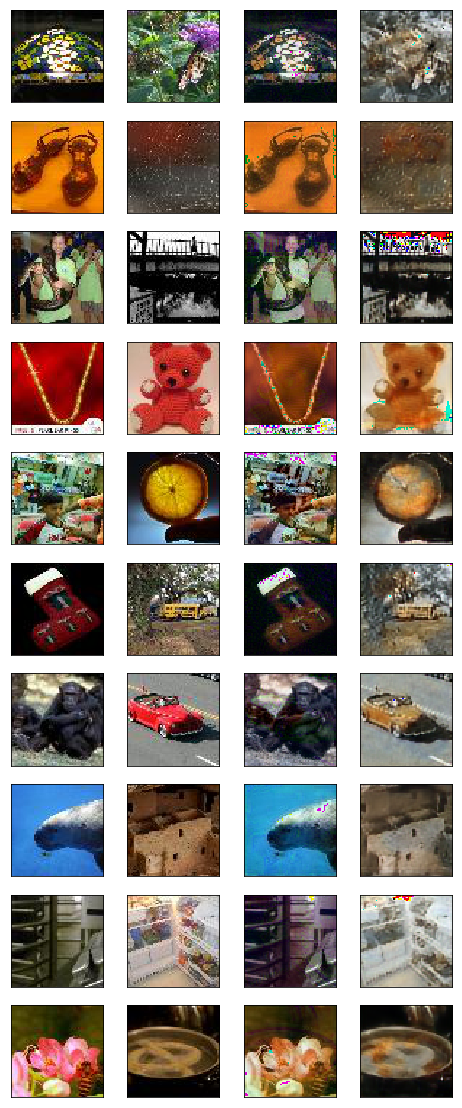

In [149]:
# Show images in gray scale
SHOW_GRAY = False
n = 10
plt.figure(figsize=(8, 20))

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

rand_indx = [random.randint(0, 1000) for x in range(n)]
# for i, idx in enumerate(range(0, n)):
for i, idx in enumerate(rand_indx):
    ax = plt.subplot(n,4, i * 4 + 1)
    if SHOW_GRAY:
        plt.imshow(rgb2gray(input_C[idx]), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(input_C[idx])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(n,4, i * 4 + 2)
    if SHOW_GRAY:
        plt.imshow(rgb2gray(input_S[idx]), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(input_S[idx])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(n, 4, i * 4 + 3)
    if SHOW_GRAY:
        plt.imshow(rgb2gray(decoded_C[idx]), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(decoded_C[idx])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(n, 4, i * 4 + 4)
    if SHOW_GRAY:
        plt.imshow(rgb2gray(decoded_S[idx]), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(decoded_S[idx])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()